In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [87]:
df = pd.read_csv("../data/clean_subject_data.csv")
df.head()

,clean_question,subject
0,present status ongoingpending railway projects...,RAILWAY PROJECTS
1,whether railways conducted study distinguish r...,RAILWAY PROJECTS
2,number anganwadi centres awcs operating countr...,ANGANWADI CENTRES
3,average coal production underground well open ...,PRODUCTION OF COAL
4,details funds allocated released government st...,ANGANWADI CENTRES


In [88]:
df.dropna(inplace=True)

In [89]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['subject'])

with open("../model/subject_label_encoder.pkl", 'wb') as f:
    pickle.dump(le,f)

num_classes = len(le.classes_)
print(num_classes)

10


In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df['clean_question'] = df['clean_question'].astype(str)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_question'])

with open("../model/subject_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

sequences = tokenizer.texts_to_sequences(df['clean_question'])

max_len = max([len(seq) for seq in sequences])
padded = pad_sequences(sequences, maxlen=max_len, padding='post')
vocab_size = len(tokenizer.word_index) + 1

print(f"Max sequence length: {max_len}")
print(f"Vocab size: {vocab_size}")

Max sequence length: 96
Vocab size: 2539


In [91]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = padded
y = to_categorical(df['label'], num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout,SimpleRNN

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build model with input shape and print summary
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 96, 100)        │       253,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,270 (1.03 MB)

 Trainable params: 269,270 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2)

Epoch 1/10


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1031 - loss: 2.3149 - val_accuracy: 0.1031 - val_loss: 2.2881
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1548 - loss: 2.2796 - val_accuracy: 0.0619 - val_loss: 2.3299
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1629 - loss: 2.2232 - val_accuracy: 0.1031 - val_loss: 2.2957
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1708 - loss: 2.1829 - val_accuracy: 0.1753 - val_loss: 2.2693
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3227 - loss: 2.0421 - val_accuracy: 0.1237 - val_loss: 2.3203
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3854 - loss: 1.9210 - val_accuracy: 0.1340 - val_loss: 2.3442
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4801 - loss: 1.6681 - val_accuracy: 0.1856 - val_loss: 2.3547
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5193 - loss: 1.5059 - val_accuracy: 0.2165 - val_loss: 2.

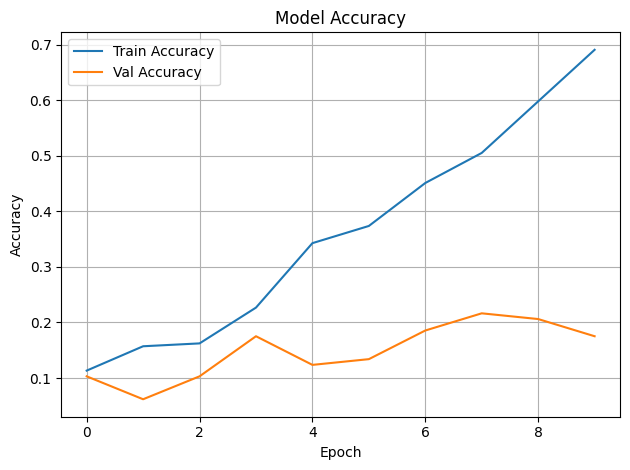

In [98]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
model.save("../model/subject_rnn_model.h5")